In [1]:
# ML Models
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Grid Search
from sklearn.model_selection import GridSearchCV

# Encoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Scaling and Imputing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Cross Validation
from sklearn.model_selection import KFold

# Metrics
from sklearn import metrics, model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Train test split
from sklearn.model_selection import train_test_split

# Misc
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import pickle

# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

# Seed for reproducability
seed = 1234
np.random.seed(seed)

## Data Importing

In [2]:
matchesHome = '../input/match-winner-prediction-dataset/matchHome.csv'
matchesNeutral = '../input/match-winner-prediction-dataset/matchNeutral.csv'

## Feature Extraction

### Creating Features

In [3]:
matchesNeut = pd.read_csv(matchesNeutral, low_memory=False)
matchesNeut.columns = matchesNeut.columns.str.strip()
matchesNeut['isNeutral'] = True

matchesHom = pd.read_csv(matchesHome, low_memory=False)
matchesHom.columns = matchesHom.columns.str.strip()

matchesHom['isNeutral'] = False

df = pd.concat([matchesHom, matchesNeut], axis=0, ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ignore_index=True)
df = df.reset_index(inplace=False, drop=True)
df

column_values = df[["home", "away"]].values.ravel()
unique_values =  pd.unique(column_values)

In [4]:
df

,home,result,margin,ballRemaining,toss,bat,away,ground,date,isNeutral
0,Australia,won,5 wickets,42.0,won,2nd,England,Melbourne,1971-01-05,False
1,England,won,6 wickets,35.0,lost,2nd,Australia,Manchester,1972-08-24,False
2,England,lost,5 wickets,21.0,lost,1st,Australia,Lord's,1972-08-26,False
3,England,won,2 wickets,21.0,won,2nd,Australia,Birmingham,1972-08-28,False
4,New Zealand,won,22 runs,NaN,lost,1st,Pakistan,Christchurch,1973-02-11,False
...,...,...,...,...,...,...,...,...,...,...
4246,Oman,won,7 wickets,35.0,lost,2nd,P.N.G.,Dubai (DSC),2022-04-12,True
4247,Scotland,won,123 runs,NaN,won,1st,P.N.G.,Dubai (DSC),2022-04-13,True
4248,Scotland,won,2 wickets,1.0,lost,2nd,Oman,Dubai (DSC),2022-04-15,True
4249,Oman,won,85 runs,NaN,won,1st,P.N.G.,Dubai (DSC),2022-04-16,True


In [5]:
df[['margin1','margin2']] = df.margin.str.split(" ",expand=True)

In [6]:
df.loc[df['margin2'] == "runs", 'ballRemaining'] = df['margin1']
df["ballRemaining"] = df["ballRemaining"].astype(str).astype(float)

In [7]:
df.drop(['margin1', 'margin2', 'date', 'margin', 'ground'], axis=1, inplace=True)

In [8]:
scaler = MinMaxScaler()
df[['ballRemaining']] = scaler.fit_transform(df[['ballRemaining']])

In [9]:
df

,home,result,ballRemaining,toss,bat,away,isNeutral
0,Australia,won,0.144828,won,2nd,England,False
1,England,won,0.120690,lost,2nd,Australia,False
2,England,lost,0.072414,lost,1st,Australia,False
3,England,won,0.072414,won,2nd,Australia,False
4,New Zealand,won,0.075862,lost,1st,Pakistan,False
...,...,...,...,...,...,...,...
4246,Oman,won,0.120690,lost,2nd,P.N.G.,True
4247,Scotland,won,0.424138,won,1st,P.N.G.,True
4248,Scotland,won,0.003448,lost,2nd,Oman,True
4249,Oman,won,0.293103,won,1st,P.N.G.,True


In [10]:
winlast1 = dict.fromkeys(unique_values, 0)
winlast2 = dict.fromkeys(unique_values, 0)
winlast3 = dict.fromkeys(unique_values, 0)
winlast4 = dict.fromkeys(unique_values, 0)
winlast5 = dict.fromkeys(unique_values, 0)
losslast1 = dict.fromkeys(unique_values, 0)
losslast2 = dict.fromkeys(unique_values, 0)
losslast3 = dict.fromkeys(unique_values, 0)
losslast4 = dict.fromkeys(unique_values, 0)
losslast5 = dict.fromkeys(unique_values, 0)
drawlast1 = dict.fromkeys(unique_values, 0)
drawlast2 = dict.fromkeys(unique_values, 0)
drawlast3 = dict.fromkeys(unique_values, 0)
drawlast4 = dict.fromkeys(unique_values, 0)
drawlast5 = dict.fromkeys(unique_values, 0)

lst = [0] * 30
# teamName = 'Australia'
df[[
    'home_last_5_win', 'home_last_4_win', 'home_last_3_win', 'home_last_2_win', 'home_last_1_win', 'away_last_5_win', 
    'away_last_4_win', 'away_last_3_win', 'away_last_2_win', 'away_last_1_win', 'home_last_5_loss', 'home_last_4_loss', 
    'home_last_3_loss', 'home_last_2_loss', 'home_last_1_loss', 'away_last_5_loss', 'away_last_4_loss', 'away_last_3_loss', 
    'away_last_2_loss', 'away_last_1_loss', 'home_last_5_draw', 'home_last_4_draw', 'home_last_3_draw', 'home_last_2_draw', 
    'home_last_1_draw', 'away_last_5_draw', 'away_last_4_draw', 'away_last_3_draw', 'away_last_2_draw', 'away_last_1_draw'
   ]] = pd.DataFrame([lst], index=df.index)

for i, row in df.iterrows():
    home = row['home']
    away = row['away']
    result = row['result']

    df.loc[i, 'home_last_5_win'] = winlast5[home]
    df.loc[i, 'away_last_5_win'] = winlast5[away]
    df.loc[i, 'home_last_5_loss'] = losslast5[home]
    df.loc[i, 'away_last_5_loss'] = losslast5[away]
    df.loc[i, 'home_last_5_draw'] = drawlast5[home]
    df.loc[i, 'away_last_5_draw'] = drawlast5[away]
    df.loc[i, 'home_last_4_win'] = winlast4[home]
    df.loc[i, 'away_last_4_win'] = winlast4[away]
    df.loc[i, 'home_last_4_loss'] = losslast4[home]
    df.loc[i, 'away_last_4_loss'] = losslast4[away]
    df.loc[i, 'home_last_4_draw'] = drawlast4[home]
    df.loc[i, 'away_last_4_draw'] = drawlast4[away]
    df.loc[i, 'home_last_3_win'] = winlast3[home]
    df.loc[i, 'away_last_3_win'] = winlast3[away]
    df.loc[i, 'home_last_3_loss'] = losslast3[home]
    df.loc[i, 'away_last_3_loss'] = losslast3[away]
    df.loc[i, 'home_last_3_draw'] = drawlast3[home]
    df.loc[i, 'away_last_3_draw'] = drawlast3[away]
    df.loc[i, 'home_last_2_win'] = winlast2[home]
    df.loc[i, 'away_last_2_win'] = winlast2[away]
    df.loc[i, 'home_last_2_loss'] = losslast2[home]
    df.loc[i, 'away_last_2_loss'] = losslast2[away]
    df.loc[i, 'home_last_2_draw'] = drawlast2[home]
    df.loc[i, 'away_last_2_draw'] = drawlast2[away]
    df.loc[i, 'home_last_1_win'] = winlast1[home]
    df.loc[i, 'away_last_1_win'] = winlast1[away]
    df.loc[i, 'home_last_1_loss'] = losslast1[home]
    df.loc[i, 'away_last_1_loss'] = losslast1[away]
    df.loc[i, 'home_last_1_draw'] = drawlast1[home]
    df.loc[i, 'away_last_1_draw'] = drawlast1[away]
    if result == 'won':      
        homeWin = 1
        awayWin = 0
        homeLoss = 0
        awayLoss = 1
        homeDraw = 0
        awayDraw = 0
    elif result == 'lost':
        homeWin = 0
        awayWin = 1
        homeLoss = 1
        awayLoss = 0
        homeDraw = 0
        awayDraw = 0
    else:
        homeWin = 0
        awayWin = 0
        homeLoss = 0
        awayLoss = 0
        homeDraw = 1
        awayDraw = 1
    
    winlast5[home] = winlast4[home] + homeWin
    winlast4[home] = winlast3[home] + homeWin
    winlast3[home] = winlast2[home] + homeWin
    winlast2[home] = winlast1[home] + homeWin
    winlast1[home] = homeWin
    
    winlast5[away] = winlast4[away] + awayWin
    winlast4[away] = winlast3[away] + awayWin
    winlast3[away] = winlast2[away] + awayWin
    winlast2[away] = winlast1[away] + awayWin
    winlast1[away] = awayWin
    
    losslast5[home] = losslast4[home] + homeLoss
    losslast4[home] = losslast3[home] + homeLoss
    losslast3[home] = losslast2[home] + homeLoss
    losslast2[home] = losslast1[home] + homeLoss
    losslast1[home] = homeLoss

    losslast5[away] = losslast4[away] + awayLoss
    losslast4[away] = losslast3[away] + awayLoss
    losslast3[away] = losslast2[away] + awayLoss
    losslast2[away] = losslast1[away] + awayLoss
    losslast1[away] = awayLoss

    drawlast5[home] = drawlast4[home] + homeDraw
    drawlast4[home] = drawlast3[home] + homeDraw
    drawlast3[home] = drawlast2[home] + homeDraw
    drawlast2[home] = drawlast1[home] + homeDraw
    drawlast1[home] = homeDraw

    drawlast5[away] = drawlast4[away] + awayDraw
    drawlast4[away] = drawlast3[away] + awayDraw
    drawlast3[away] = drawlast2[away] + awayDraw
    drawlast2[away] = drawlast1[away] + awayDraw
    drawlast1[away] = awayDraw

## Data Analysis

In [11]:
winners = dict.fromkeys(unique_values, 0)
total = dict.fromkeys(unique_values, 0)
for i, row in df.iterrows():
    total[df.at[i, 'home']] += 1
    total[df.at[i, 'away']] += 1
    if df.at[i, 'result'] == 'won':
        winners[df.at[i, 'home']] += 1
    elif df.at[i, 'result'] == 'loss':
        winners[df.at[i, 'away']] += 1

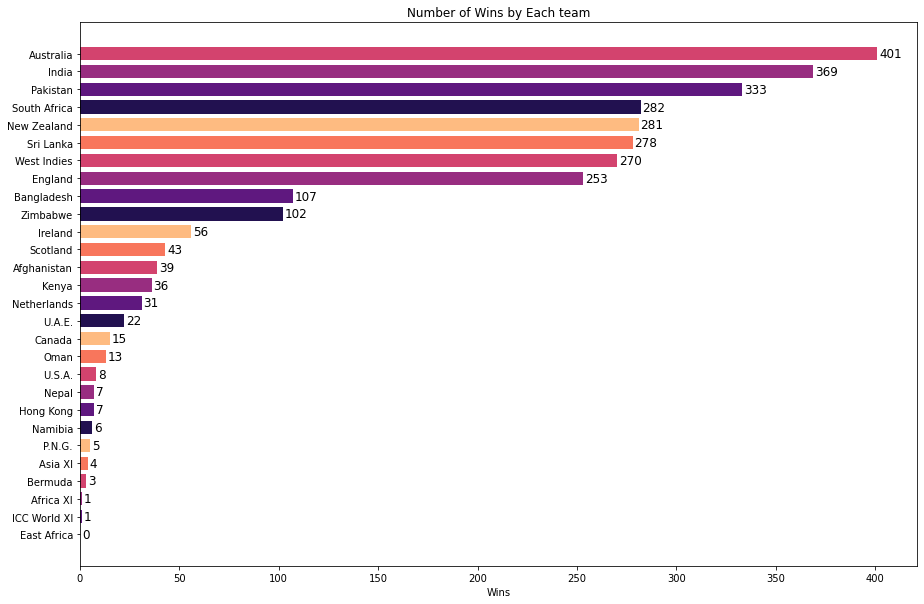

In [12]:
winners = dict(sorted(winners.items(), key=lambda item: item[1]))
names = list(winners.keys())
values = list(winners.values())
temp = pd.DataFrame(list(zip(names, values)))
temp.columns = ['Teams','Wins']
plt.figure(figsize=(15,10))
plt.barh(temp['Teams'], temp['Wins'], height=0.75, color=sns.color_palette("magma"))
plt.xlabel('Wins') 
plt.title("Number of Wins by Each team")
for i, v in enumerate(values):
    plt.text(v+1, i, str(v), color='black', fontweight='normal', fontsize=12, ha='left', va='center')
plt.show()

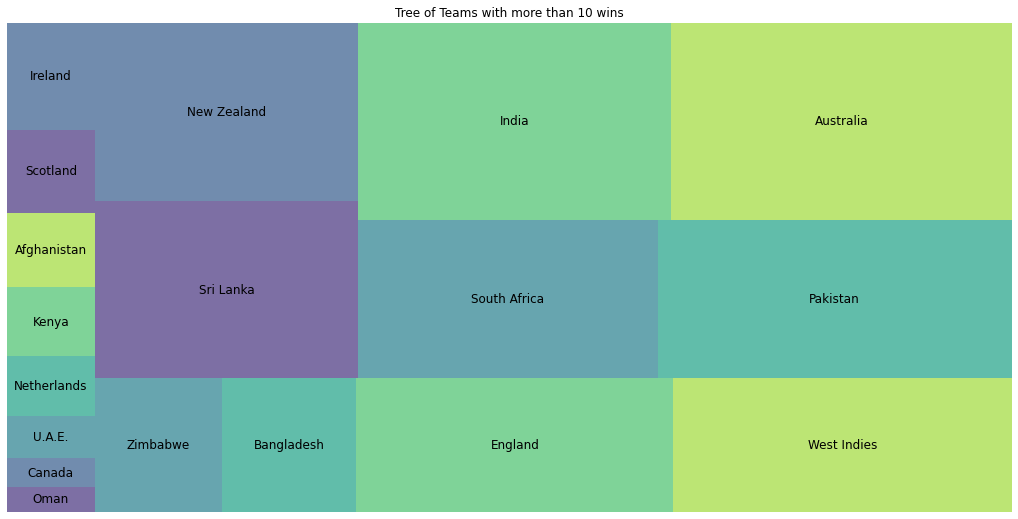

In [13]:
temp = temp[temp.Wins > 10]
temp['Wins'] = temp['Wins'].astype(int)
plt.figure(figsize=(18,9))
squarify.plot(sizes=temp['Wins'], label=temp['Teams'], alpha=0.7, color=sns.color_palette("viridis"), text_kwargs={'fontsize':12}).set(title='Tree of Teams with more than 10 wins')
plt.axis('off')
plt.show()

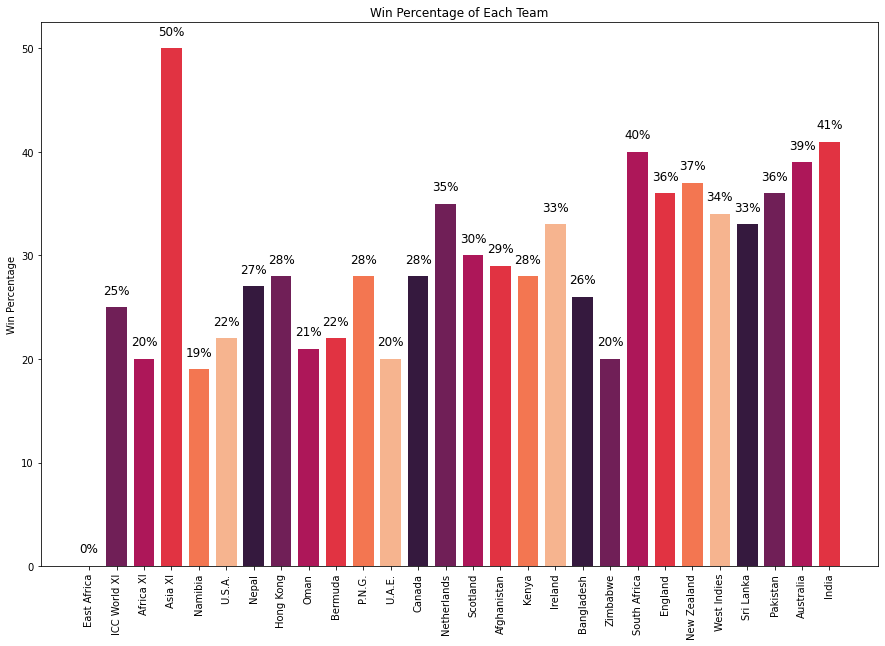

In [14]:
total = dict(sorted(total.items(), key=lambda item: item[1]))
namesT = list(total.keys())
valuesT = list(total.values())
valuesT = [int((int(b) / int(m))*100) for b,m in zip(values, valuesT)]
temp = pd.DataFrame(list(zip(namesT, valuesT)))
temp.columns = ['Teams','Wins']
plt.figure(figsize=(15,10))
plt.bar(temp['Teams'], temp['Wins'], width=0.75, color=sns.color_palette("rocket"))
plt.xticks(rotation=90)
plt.ylabel('Win Percentage') 
plt.title("Win Percentage of Each Team")
for i, v in enumerate(valuesT):
    plt.text(i, v+1, str(v) + '%', color='black', fontweight='normal', fontsize=12, ha='center', va='bottom')
plt.show()

## Handling Categorical Variables

In [15]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols

['home', 'result', 'toss', 'bat', 'away']

In [16]:
lb = LabelEncoder()
for cat_col in cat_cols:
    df.loc[:, cat_col] = lb.fit_transform(np.array(df.loc[:, cat_col]).reshape(-1, ))

## Handling Missing Values

<AxesSubplot:>

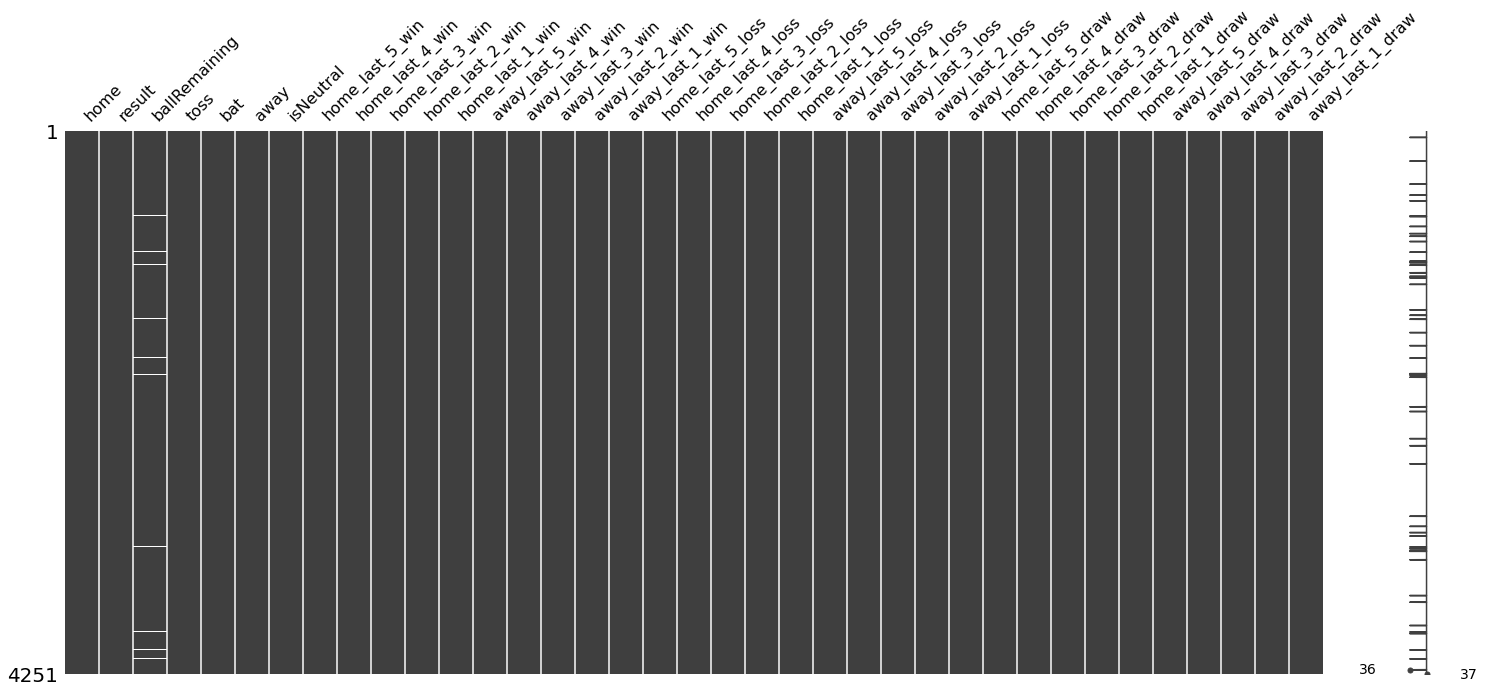

In [17]:
msno.matrix(df)

In [18]:
knn = KNNImputer(n_neighbors = 3)

In [19]:
knn_imputer = KNNImputer(n_neighbors = 3)

df_pre1 = df.copy()

X = np.round(knn_imputer.fit_transform(df_pre1))
df_pre1 = pd.DataFrame(X, columns = df_pre1.columns)

In [20]:
df_pre1

,home,result,ballRemaining,toss,bat,away,isNeutral,home_last_5_win,home_last_4_win,home_last_3_win,...,home_last_5_draw,home_last_4_draw,home_last_3_draw,home_last_2_draw,home_last_1_draw,away_last_5_draw,away_last_4_draw,away_last_3_draw,away_last_2_draw,away_last_1_draw
0,3.0,2.0,0.0,2.0,2.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,2.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,0.0,0.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.0,2.0,0.0,2.0,2.0,3.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,2.0,0.0,1.0,1.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4246,17.0,2.0,0.0,1.0,2.0,19.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4247,20.0,2.0,0.0,2.0,1.0,19.0,1.0,5.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4248,20.0,2.0,0.0,1.0,2.0,18.0,1.0,5.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4249,17.0,2.0,0.0,2.0,1.0,19.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_pre1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home              4251 non-null   float64
 1   result            4251 non-null   float64
 2   ballRemaining     4251 non-null   float64
 3   toss              4251 non-null   float64
 4   bat               4251 non-null   float64
 5   away              4251 non-null   float64
 6   isNeutral         4251 non-null   float64
 7   home_last_5_win   4251 non-null   float64
 8   home_last_4_win   4251 non-null   float64
 9   home_last_3_win   4251 non-null   float64
 10  home_last_2_win   4251 non-null   float64
 11  home_last_1_win   4251 non-null   float64
 12  away_last_5_win   4251 non-null   float64
 13  away_last_4_win   4251 non-null   float64
 14  away_last_3_win   4251 non-null   float64
 15  away_last_2_win   4251 non-null   float64
 16  away_last_1_win   4251 non-null   float64


## Test-Train_Validation Split

In [22]:
X = df_pre1.drop(columns = ['result']).copy()
y = df_pre1[['result']]

In [23]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

## Implementation using Logistic Regression

### Hyperparameter tuning using Grid Search and Cross Validation

In [24]:
parameters = {'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'max_iter': [50, 100, 200]}

### Training Model

In [25]:
logreg_cv = GridSearchCV(LogisticRegression(), parameters, cv=10)
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'max_iter': [50, 100, 200], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

### Accuracy

In [26]:
print("Accuracy:",logreg_cv.best_score_)
print("Best penalty:",logreg_cv.best_estimator_.penalty)
print("Best Max Iterations:",logreg_cv.best_estimator_.max_iter)
print("Best Solver:",logreg_cv.best_estimator_.solver)

Accuracy: 0.7244117647058823
Best penalty: l1
Best Max Iterations: 50
Best Solver: liblinear


In [27]:
classifierLR = logreg_cv.best_estimator_
Y_pred = classifierLR.predict(X_test)

### Confusion Matrix

In [28]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)

<AxesSubplot:>

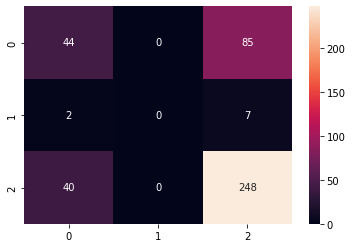

In [29]:
sns.heatmap(cm, annot=True,fmt='d')

### Classification Report

In [30]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.34      0.41       129
         1.0       0.00      0.00      0.00         9
         2.0       0.73      0.86      0.79       288

    accuracy                           0.69       426
   macro avg       0.41      0.40      0.40       426
weighted avg       0.65      0.69      0.66       426



In [31]:
print("Training Score: ", classifierLR.score(X_train, y_train))
print("Testing Score: ", classifierLR.score(X_test, y_test))

Training Score:  0.7338235294117647
Testing Score:  0.6854460093896714


### K Fold Cross Validation

In [32]:
accuracies = cross_val_score(estimator = classifierLR, X = X_val, y = y_val, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 71.28 %
Standard Deviation: 7.11 %


## Implementation using SVM

### Hyperparameter tuning using Grid Search and Cross Validation

In [33]:
parameters = {'kernel': ['linear', 'rbf'], 'gamma': ['scale']}

### Training Model

In [34]:
svc_cv = GridSearchCV(SVC(), parameters, cv=10)
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'gamma': ['scale'], 'kernel': ['linear', 'rbf']})

### Accuracy

In [35]:
print("Accuracy:",svc_cv.best_score_)
print("Best kernel:",svc_cv.best_estimator_.kernel)
print("Best Gamma:",svc_cv.best_estimator_.gamma)

Accuracy: 0.7270588235294119
Best kernel: linear
Best Gamma: scale


In [36]:
classifierSVC = svc_cv.best_estimator_
Y_pred = classifierSVC.predict(X_test)

### Confusion Matrix

In [37]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)

<AxesSubplot:>

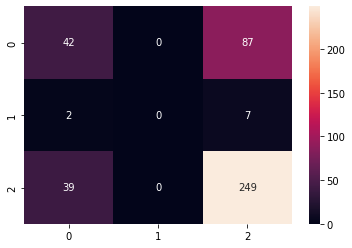

In [38]:
sns.heatmap(cm, annot=True,fmt='d')

### Classification Report

In [39]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.33      0.40       129
         1.0       0.00      0.00      0.00         9
         2.0       0.73      0.86      0.79       288

    accuracy                           0.68       426
   macro avg       0.41      0.40      0.40       426
weighted avg       0.64      0.68      0.65       426



In [40]:
print("Training Score: ", classifierSVC.score(X_train, y_train))
print("Testing Score: ", classifierSVC.score(X_test, y_test))

Training Score:  0.7364705882352941
Testing Score:  0.6830985915492958


### K Fold Cross Validation

In [41]:
accuracies = cross_val_score(estimator = classifierSVC, X = X_val, y = y_val, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 70.81 %
Standard Deviation: 6.08 %


## Implementation using Random Forest Classifier

### Hyperparameter tuning using Grid Search and Cross Validation

In [42]:
parameters = {'n_estimators': [100, 200], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}

### Training Model

In [43]:
rf_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=10)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200]})

### Accuracy

In [44]:
print("Accuracy:",rf_cv.best_score_)
print("Best Criterion:",rf_cv.best_estimator_.criterion)
print("Best Max Features:",rf_cv.best_estimator_.max_features)
print("Best N Estimators:",rf_cv.best_estimator_.n_estimators)

Accuracy: 0.7205882352941175
Best Criterion: gini
Best Max Features: log2
Best N Estimators: 200


In [45]:
classifierRF = rf_cv.best_estimator_
Y_pred = classifierRF.predict(X_test)

### Confusion Matrix

In [46]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)

<AxesSubplot:>

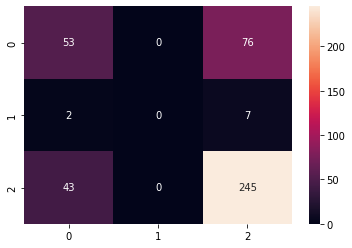

In [47]:
sns.heatmap(cm, annot=True,fmt='d')

### Classification Report

In [48]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.41      0.47       129
         1.0       0.00      0.00      0.00         9
         2.0       0.75      0.85      0.80       288

    accuracy                           0.70       426
   macro avg       0.43      0.42      0.42       426
weighted avg       0.67      0.70      0.68       426



In [49]:
print("Training Score: ", classifierRF.score(X_train, y_train))
print("Testing Score: ", classifierRF.score(X_test, y_test))

Training Score:  0.9982352941176471
Testing Score:  0.6995305164319249


### K Fold Cross Validation

In [50]:
accuracies = cross_val_score(estimator = classifierRF, X = X_val, y = y_val, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 72.25 %
Standard Deviation: 4.60 %


## Implementation using Decision Tree

### Hyperparameter tuning using Grid Search and Cross Validation

In [51]:
parameters = {'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2']}

### Training Model

In [52]:
dt_cv = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10)
dt_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'splitter': ['best', 'random']})

### Accuracy

In [53]:
print("Accuracy:",dt_cv.best_score_)
print("Best Splitter:",dt_cv.best_estimator_.splitter)
print("Best Criterion:",dt_cv.best_estimator_.criterion)
print("Best Max Features:",dt_cv.best_estimator_.max_features)

Accuracy: 0.6791176470588236
Best Splitter: best
Best Criterion: entropy
Best Max Features: sqrt


In [54]:
classifierDT = dt_cv.best_estimator_
Y_pred = classifierDT.predict(X_test)

### Confusion Matrix

In [55]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)

<AxesSubplot:>

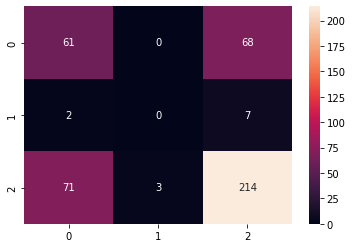

In [56]:
sns.heatmap(cm, annot=True,fmt='d')

### Classification Report

In [57]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.46      0.47      0.46       129
         1.0       0.00      0.00      0.00         9
         2.0       0.74      0.74      0.74       288

    accuracy                           0.65       426
   macro avg       0.40      0.41      0.40       426
weighted avg       0.64      0.65      0.64       426



In [58]:
print("Training Score: ", classifierDT.score(X_train, y_train))
print("Testing Score: ", classifierDT.score(X_test, y_test))

Training Score:  0.9982352941176471
Testing Score:  0.6455399061032864


### K Fold Cross Validation

In [59]:
accuracies = cross_val_score(estimator = classifierDT, X = X_val, y = y_val, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 66.83 %
Standard Deviation: 3.88 %


## Implementation using XGBoost

### Hyperparameter tuning using Grid Search and Cross Validation

In [60]:
parameters = {'booster': ['gbtree', 'gblinear', 'dart'], 'n_estimators': [10, 50, 100]}

### Training Model

In [61]:
xgb_cv = GridSearchCV(XGBClassifier(), parameters, cv=10)
xgb_cv.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
   

### Accuracy

In [62]:
print("Accuracy:",xgb_cv.best_score_)
print("Best Booster:",xgb_cv.best_estimator_.booster)
print("Best N Estimators:",xgb_cv.best_estimator_.n_estimators)

Accuracy: 0.7379411764705883
Best Booster: gbtree
Best N Estimators: 10


In [63]:
classifierXGB = xgb_cv.best_estimator_
Y_pred = classifierXGB.predict(X_test)

### Confusion Matrix

In [64]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)

<AxesSubplot:>

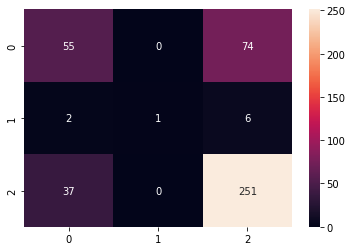

In [65]:
sns.heatmap(cm, annot=True,fmt='d')

### Classification Report

In [66]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.43      0.49       129
         1.0       1.00      0.11      0.20         9
         2.0       0.76      0.87      0.81       288

    accuracy                           0.72       426
   macro avg       0.78      0.47      0.50       426
weighted avg       0.71      0.72      0.70       426



In [67]:
print("Training Score: ", classifierXGB.score(X_train, y_train))
print("Testing Score: ", classifierXGB.score(X_test, y_test))

Training Score:  0.7964705882352942
Testing Score:  0.7206572769953051


### K Fold Cross Validation

In [68]:
accuracies = cross_val_score(estimator = classifierXGB, X = X_val, y = y_val, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 73.90 %
Standard Deviation: 4.18 %


## StackNet

In [69]:
finalLayer = StackingClassifier(
     estimators=[('xgbr', classifierXGB), 
                 ('rfc', classifierRF),
                 ('dtr', classifierDT),
                 ('svr', classifierSVC),
                 ('lor', classifierLR),
                 ],
     final_estimator= LogisticRegression(), passthrough=True, n_jobs=-1
    )
multi_layer_Classifier = StackingClassifier(
        estimators=[ 

                 ('xgbr', classifierXGB),
                 ('rfc', classifierRF)],
         final_estimator=finalLayer, passthrough=False, n_jobs=-1
   )
multi_layer_Classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('xgbr',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_bin...


In [70]:
Y_pred = multi_layer_Classifier.predict(X_test)

### Confusion Matrix

In [71]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)

<AxesSubplot:>

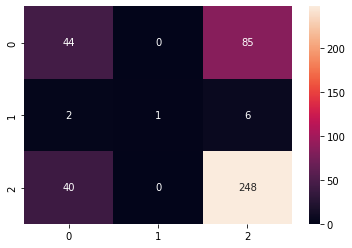

In [72]:
sns.heatmap(cm, annot=True,fmt='d')

### Classification Report 

In [73]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.34      0.41       129
         1.0       1.00      0.11      0.20         9
         2.0       0.73      0.86      0.79       288

    accuracy                           0.69       426
   macro avg       0.75      0.44      0.47       426
weighted avg       0.67      0.69      0.66       426



In [74]:
print(f"Accuracy Score is {accuracy_score(y_test, Y_pred)}")

Accuracy Score is 0.687793427230047


### K Fold Cross Validation

In [75]:
accuracies = cross_val_score(estimator = multi_layer_Classifier, X = X_val, y = y_val, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 69.17 %
Standard Deviation: 3.91 %


**Clearly XG Boost is the best model with cross-validation accuracy of 74%, and relatively low standard deviation.**

## Saving Files for Web App

### Saving Model

In [76]:
from joblib import dump
dump(classifierXGB, 'XGBoost.joblib')

['XGBoost.joblib']

### Saving encoded variables

In [77]:
# le_dict = dict(zip(lb.classes_, lb.transform(lb.classes_)))

In [78]:
with open('winlast.pkl', 'wb') as f: 
    pickle.dump([winlast5, winlast4, winlast3, winlast2, winlast1], f)

In [79]:
with open('losslast.pkl', 'wb') as f: 
    pickle.dump([losslast5, losslast4, losslast3, losslast2, losslast1], f)

In [80]:
with open('drawlast.pkl', 'wb') as f: 
    pickle.dump([drawlast5, drawlast4, drawlast3, drawlast2, drawlast1], f)